# Topic Modeling with NMF and SVD

## Intro to NLP

Natural Language Processing is a broad field encompassing a variety of tasks, including:

* Part-of-speech tagging: Identify if each word is noun, verb, adjective, etc
* Named entity recognition NER: Identify person names, organizations, locations, medical codes, time expressions, quantities, monetary values, etc
* Question answering
* Speech recognition
* Text-to-speech and Speech-to-text
* Topic modelling
* Sentiment classification
* Language modeling
* Translation

The field is still very much is a state of flux, with best practices changing:

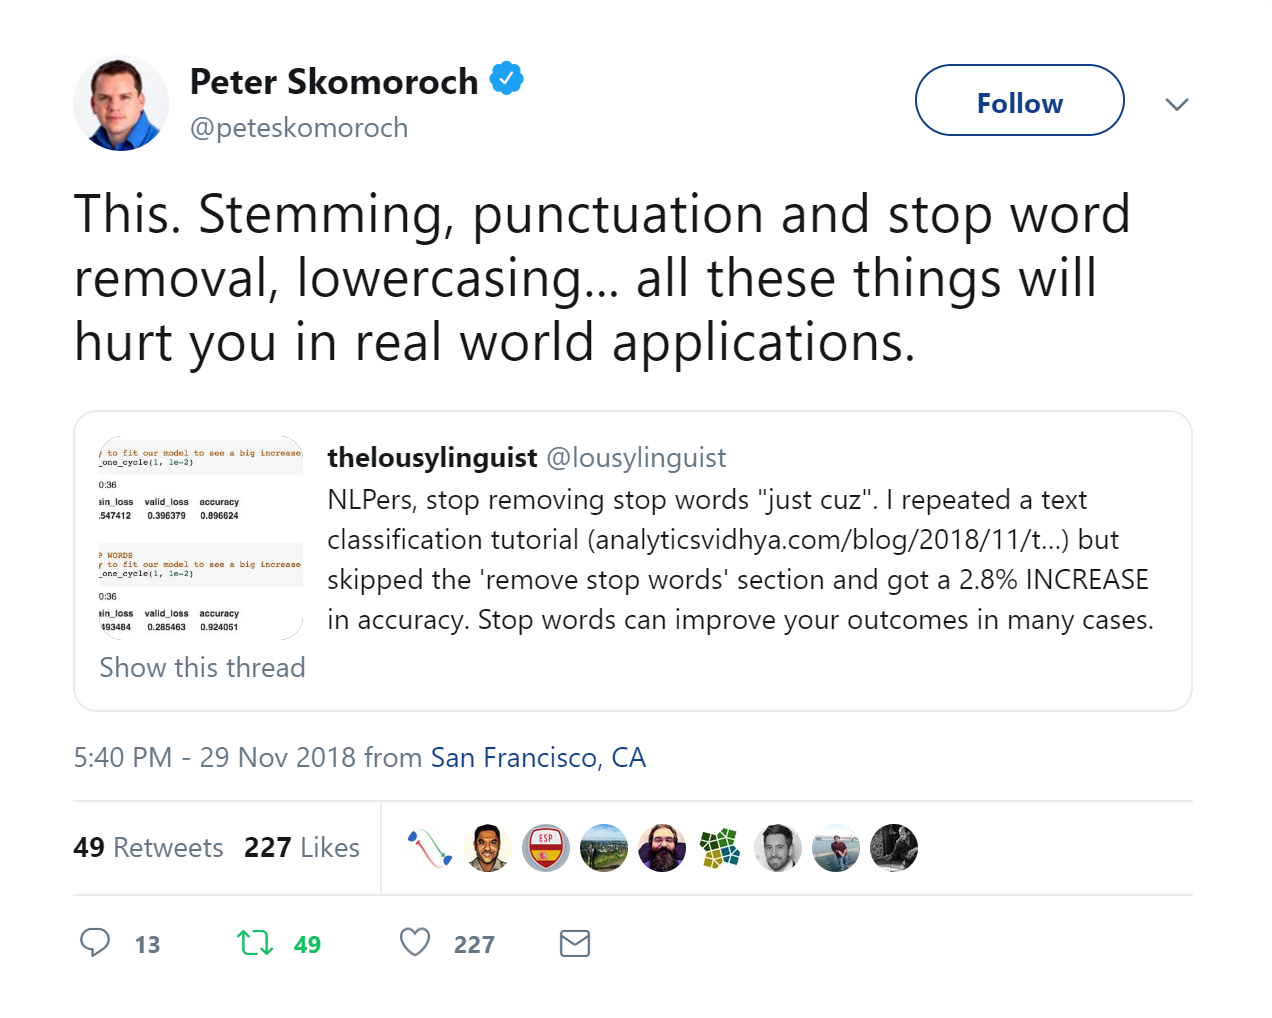


How will we prevent AI-Based Forgery?

## Getting Started

We'll take a dataset of documents in several different categories, and find topics (consisting of groups of words) for them. Knowing the actual categories helps us evaluate if the topics we find make sense.

We will try this with two different matrix factorizations: **Singular Value Decomposition (SVD)** and **Non-negative Matrix Factorization (NMF)**

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
np.set_printoptions(suppress=True)

# Disable jedi autocompleter
%config Completer.use_jedi = False

plt.rcParams["figure.figsize"] = 10,8

## Look at the Data

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [4]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

Let's look at some of the data:

In [5]:
print("\n".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

In [6]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

In [7]:
# The target attribute is the integer index of the category:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

In [8]:
num_topics, num_top_words = 6, 8

## Stop Words, Stemming, Lemmatization

### Stop Words

Some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words.

The general trend in Information Retrieval (IR) systems over time has been from standard use of quite large stop lists (200-300 terms) to very small stop lists (7-12 terms) to no stop list whatsoever. Web search engines generally do not use stop lists.

### NLTK

In [9]:
from sklearn.feature_extraction import _stop_words
sorted(list(_stop_words.ENGLISH_STOP_WORDS))[:20]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst']

There is no single universal list of stop words

### Stemming and Lemmatization

Both generate the root form of the words.
Lemmatization uses the rules about a language. The resulting tokens are all actual words.  
"Stemming is the poor-man's lemmatization". Stemming is a crude heuristic that chops the ends off of words. The resulting token may not be actual words. Stemming is faster.


In [10]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/athena/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
from nltk import stem

In [12]:
# Lemmatize using wordnet
# Initiate lemmatizer
wnl = stem.WordNetLemmatizer()

# word stemmer based on the Porter stemming algorithm
# Initiate stemmer
porter = stem.porter.PorterStemmer()

In [13]:
word_list = ['fly', 'flies', 'flying']
#['feet', 'foot', 'foots', 'footing']

[wnl.lemmatize(word) for word in word_list]

['fly', 'fly', 'flying']

In [14]:
[porter.stem(word) for word in word_list]

['fli', 'fli', 'fli']

## Spacy

Stemming and lemmatization are implementation dependent.

Spacy is a very modern & fast nlp library. Spacy is opinionated, in that is typically offers one highly optimized way to do something

In [15]:
import spacy

In [16]:
nlp = spacy.load("en_core_web_sm")

In [17]:
# Stop words that are in spacy but not in sklearn
set(nlp.Defaults.stop_words) - set(_stop_words.ENGLISH_STOP_WORDS)

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'ca',
 'did',
 'does',
 'doing',
 'just',
 'make',
 "n't",
 'n‘t',
 'n’t',
 'quite',
 'really',
 'regarding',
 'say',
 'unless',
 'used',
 'using',
 'various',
 '‘d',
 '‘ll',
 '‘m',
 '‘re',
 '‘s',
 '‘ve',
 '’d',
 '’ll',
 '’m',
 '’re',
 '’s',
 '’ve'}

In [18]:
# Stop words that are in sklearn but not in spacy
set(_stop_words.ENGLISH_STOP_WORDS) - set(nlp.Defaults.stop_words)

{'amoungst',
 'bill',
 'cant',
 'co',
 'con',
 'couldnt',
 'cry',
 'de',
 'describe',
 'detail',
 'eg',
 'etc',
 'fill',
 'find',
 'fire',
 'found',
 'hasnt',
 'ie',
 'inc',
 'interest',
 'ltd',
 'mill',
 'sincere',
 'system',
 'thick',
 'thin',
 'un'}

### When to Use These?

These were long considered standard techniques, but they can often hurt your performance if using deep learning. Stemming, lemmatization, and removing stop words all involve throwing away information.

However, they can still be useful when working with simpler models.

### Another approach: sub-word units

[SentencePiece](https://github.com/google/sentencepiece) library from Google

## Data Processing
Next, scikit learn has a method that will extract all the word counts for us.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk

In [20]:
vectorizer = CountVectorizer(stop_words='english')

In [21]:
# Learn the vocabulary dictionary and return document-term matrix
vectors = vectorizer.fit_transform(newsgroups_train.data).todense()
vectors.shape

(2034, 26576)

In [22]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [23]:
vocab = np.array(vectorizer.get_feature_names())

In [24]:
vocab.shape

(26576,)

In [25]:
vocab[6000:6020]

array(['cleveland', 'clever', 'cleverer', 'cleverly', 'cli',
       'cliberbuiten', 'clibstatus', 'clibsucces', 'cliche', 'click',
       'clicking', 'clicks', 'client', 'clients', 'cliff', 'climate',
       'climatic', 'climatologist', 'climbed', 'clime'], dtype='<U80')

## SVD

Latent Semantic Analysis (LSA) uses SVD. You will sometimes hear topic modelling referred to as LSA

In [26]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 3min 19s, sys: 4.78 s, total: 3min 24s
Wall time: 2min 10s


Keep in mind that we calculated the reduced SVD (`full_matrices=False`). For the full SVD, both $U$ and $V$ are **square** matrices, where the extra columns in $U$ form an orhtonormal basis (but zeros out when multiplied by extra rows of zeros in S).

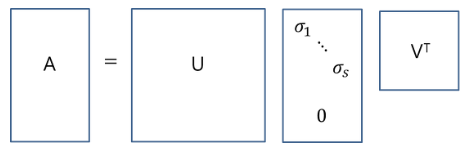

If $S$ is reduced to $s \times s$, a reduced SVD can be generated as shown below:

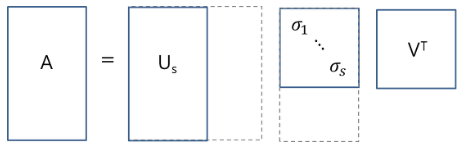

In [27]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


In [28]:
vectors.shape

(2034, 26576)

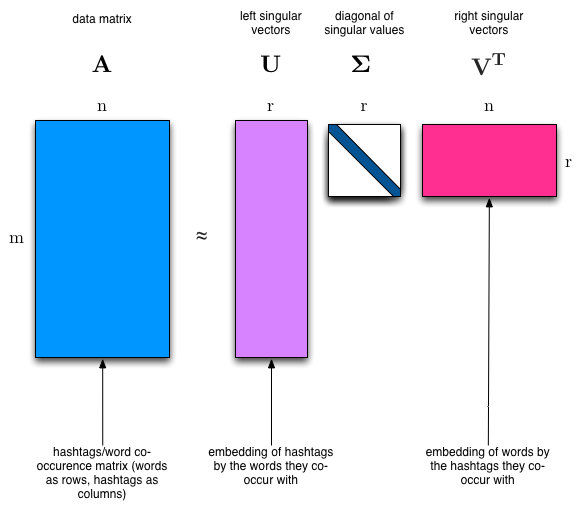

In [30]:
# Exercise: confrim that U, s, Vh is a decomposition of `vectors`
# we start by reconstructing the vector A:
# Since s showed up as vector we need a function to changed to a matrix:
# that is np.diag(vec)
reconstructed_vectors = U @ np.diag(s) @ Vh
np.allclose(reconstructed_vectors, vectors)

# Aternative way:
# np.linalg.norm(reconstructed_vectors - vectors)

True

In [37]:
# Exercise: Confirm that U as well as Vh are othonormal
# 1. U
# Make sure that you are multiplying it at the correct side
# In U it's the columns that are orthnormals
# In U 
np.allclose(U.T @ U, np.eye(U.shape[0]))

True

In [38]:
# 2. Vh:
np.allclose(Vh @ Vh.T, np.eye(Vh.shape[0]))

True

### Topics

What can we say about the singular values s?

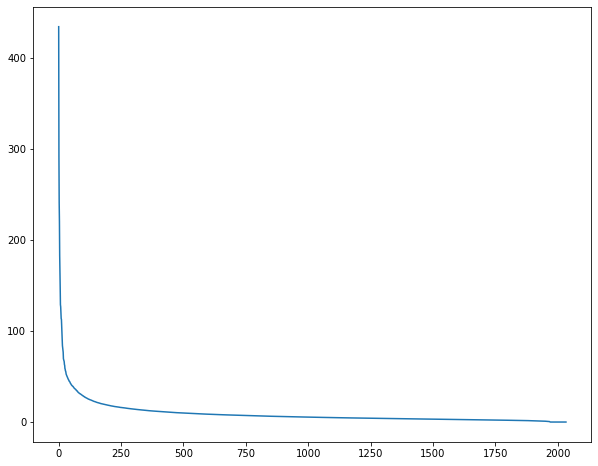

In [40]:
plt.plot(s);

The singular values are telling the importance about a topic

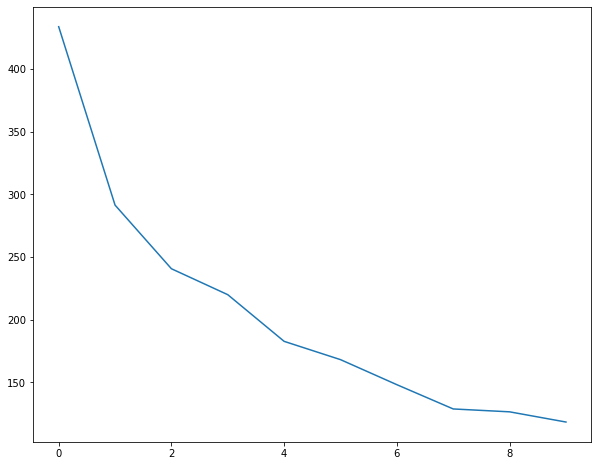

In [41]:

plt.plot(s[:10])

In [43]:
# A help method to display important topics
num_top_words = 8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]


In [44]:
show_topics(Vh[:10])

['critus ditto propagandist surname galacticentric kindergarten surreal imaginative',
 'edu graphics data space pub mail 128 3d',
 'space jesus launch god people satellite matthew atheists',
 'space launch satellite commercial nasa satellites market year',
 'jpeg graphics space pub edu ray mail send',
 'jesus matthew prophecy messiah psalm isaiah david said',
 'launch commercial satellite market image services satellites launches',
 'data available nasa ftp grass anonymous contact gov',
 'atheists god religious atheism religion believe belief atheist',
 'probe data surface moon mars probes lunar launch']

We get topics that match the kinds of clusters we would expect! This is despite the fact that this is an **unsupervised algorithm** -- which is to say, we never actually told the algorithm how our documents are grouped.

## Non-negative Matrix Factorization (NMF)

Rather than constraining our factors to be *orthogonal*, another idea would to constrain them to be *non-negative*. NMF is a factorization of anon-negative data set $V$:

$$V = WH$$

into non-negative matices $W$, $H$. Often positive factors will be more easily interpretable (and this is the reaon behind NMF's popularity)

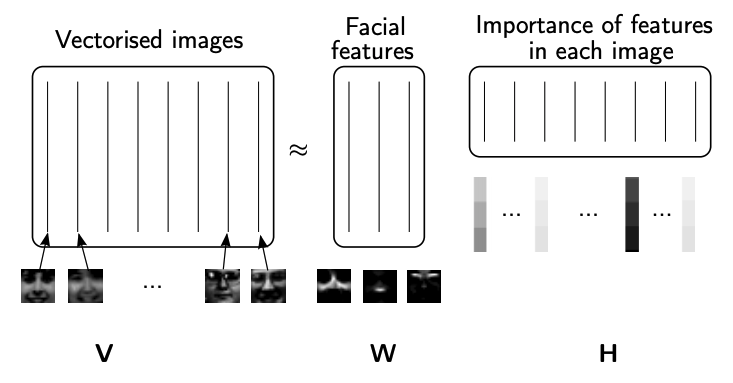

<div class="alert alert-block alert-info">
NMF is a non-exact factorization that factors into one skinny positive matrix and one short positive matrix. MF is NP-hard and non-unique. There are a number of variations on it, created by adding different constraints.</div>

NMF provides a unsupervised linear representation of the data:

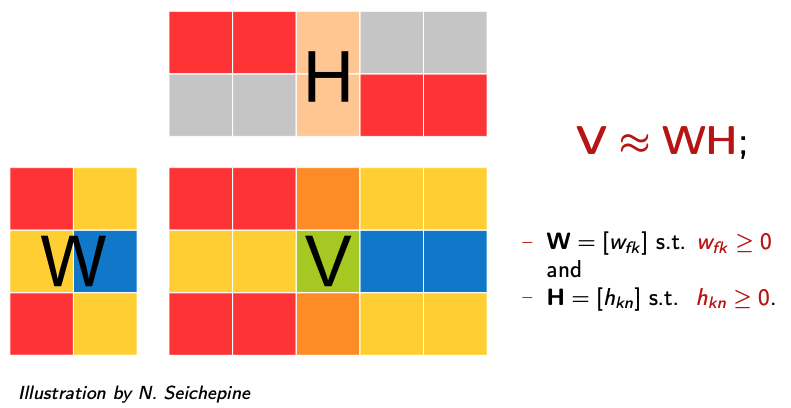

### General Usages of NMF

* Feature Learning: like Principal Component Analysis (PCA)
* Clustering: like K-means.
    * NMF can handle overlapping cluster and provides soft cluster membership indications
* Temporal Segmentation: like hidden Markov Models (HMM)
* Topics Recovery: : like Probabilistic Latent Semantic Analysis (PLSA)
* Filtering and source separation: as with Independent Component Analysis (ICA);
* coding as with vector quantization

### Applications of NMF

* Face decompositions
* Collaborative filtering, e.g. movie recommendations
* Audio source separation
* Chemistry
* Bioinformatics and gene expression
* Topic Modeling:

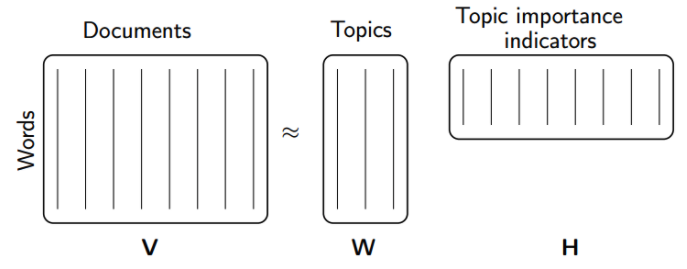

### NMF with `sklearn`



In [47]:
m, n = vectors.shape
# number of topics
n_topics = 5

In [49]:
clf = decomposition.NMF(n_components=n_topics, random_state=23)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

/Users/athena/opt/miniconda3/envs/mlpocref/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


In [50]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

### TF-IDF

Topic Frequency-Inverse Document Frequency (TF-IDF) is a way to normalize term counts by taking into account how often they appear in a document, how long the document is, and how coommon/rare the term is.

TF = (# occurences of term t in document) / (# of words in documents)
IDF = log(# of documents / # documents with term t in it)

In [51]:
# Convert a collection of raw documents to a matrix of TF-IDF features
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
# Learn vocabulary and idf, return document-term matrix
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data)

In [52]:
newsgroups_train.data[10:15]

["a\n\nWhat about positional uncertainties in S-L 1993e?   I assume we know where\nand what Galileo is doing within a few meters.   But without the\nHGA,  don't we have to have some pretty good ideas, of where to look\nbefore imaging?  If the HGA was working,  they could slew around\nin near real time (Less speed of light delay).  But when they were\nimaging toutatis????  didn't someone have to get lucky on a guess to\nfind the first images?   \n\nAlso, I imagine S-L 1993e will be mostly a visual image.  so how will\nthat affect the other imaging missions.  with the LGA,  there is a real\ntight allocation of bandwidth.   It may be premature to hope for answers,\nbut I thought i'd throw it on the floor.",
 "I would like to program Tseng ET4000 to nonstandard 1024x768 mode by\nswitching to standard 1024x768 mode using BIOS and than changing some\ntiming details (0x3D4 registers 0x00-0x1F) but I don't know how to\nselect 36 MHz pixel clock I need. The BIOS function selects 40 MHz.\n\nIs t

In [54]:
# Learn a NMF model for the data X and returns the transformed data.
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_
show_topics(H1)

/Users/athena/opt/miniconda3/envs/mlpocref/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

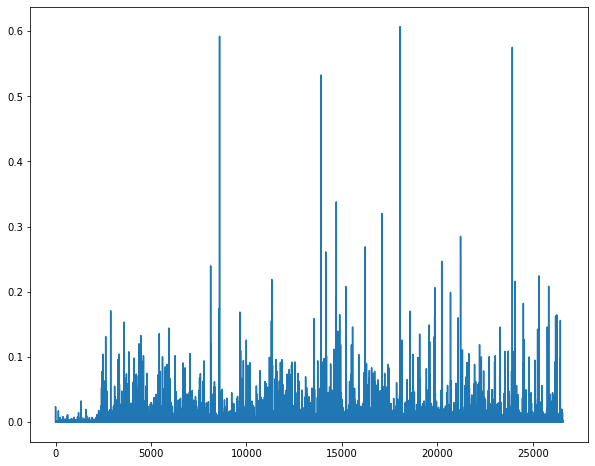

In [55]:
plt.plot(clf.components_[0])

In [56]:
clf.reconstruction_err_

43.71292605803645

### NMF in Summary

* Benefits: fast and easy to use!
* Downsides:took years of research and expertise to create

## Truncated SVD

We saved a lot of time when we calculated NMF by only calculating the subset of columns we were interested in. Is there a way to get this benefit with SVD?
Yes there is and it's called *truncated SVD*. We are just interested in the vectors corresponding to the largest singular values.

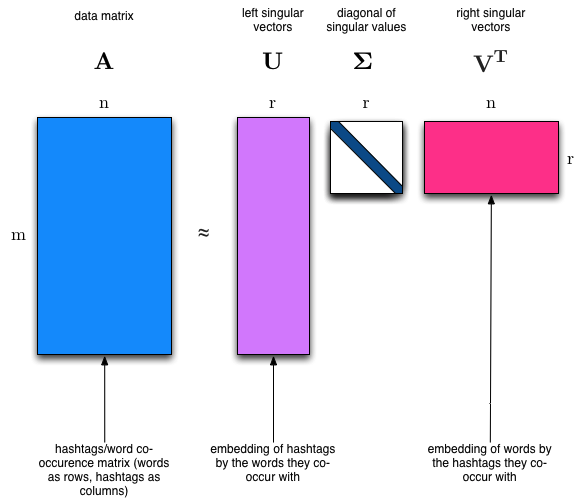

### Shortcoming of classical algorithms for decomposition

* Matrices are "stupendously big"
* Data are often missing or innacurate. Why spend extra computational resources when imprecision of input limits precision of the output?
* Data transfer now plays a major role in time of algorithms. Techniques the require fewer passes over the data may be substantially faster, even if they require more flops (flops = floating point operations).
* Important to take advantage of GPUs.

### Advantages of randomized algorithms

* Inherently stable
* Performance guarantee do not depend on subtle spectral properties
* needed matrxi-vector products can be done in parallel

In [57]:
from sklearn import decomposition
import fbpca

In [58]:
%time u, s, v = decomposition.randomized_svd(vectors, 10)

CPU times: user 10.4 s, sys: 3.71 s, total: 14.1 s
Wall time: 11 s


In [59]:
# Randomized SVD from Facebook's library fbpca:
%time u, s, v = fbpca.pca(vectors, 10)

CPU times: user 2.65 s, sys: 1.19 s, total: 3.84 s
Wall time: 2.55 s
